In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
!unzip cats_and_dogs_filtered.zip

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

In [4]:
data_root = '/content/cats_and_dogs_filtered'

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
img = image.load_img('/content/cats_and_dogs_filtered/train/cats/cat.110.jpg')
type(img)

PIL.JpegImagePlugin.JpegImageFile

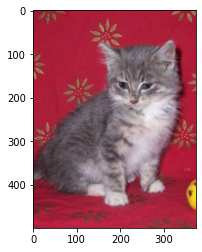

In [7]:
plt.imshow(img)
plt.show()

In [8]:
x = image.img_to_array(img)
x.shape, type(x), x.dtype

((500, 374, 3), numpy.ndarray, dtype('float32'))

In [9]:
x = x.astype('int').reshape(1, 500, 374, 3)
x.shape

(1, 500, 374, 3)

In [10]:
gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    vertical_flip = True,
    horizontal_flip = True
)

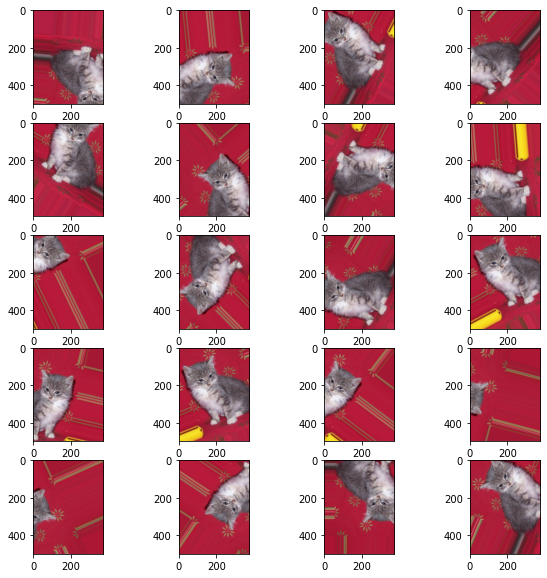

In [11]:
fig = plt.figure(figsize=(10,10))
idx = 0
axs = []

for batch in gen.flow(x, batch_size=1):
  axs.append(fig.add_subplot(5,4,idx+1))
  axs[idx].imshow(image.array_to_img(batch[0]))
  idx += 1
  if idx%20 == 0:
    break

plt.show()

## 경로설정

In [12]:
import os
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'validation')

In [13]:
train_gen = ImageDataGenerator(
    rescale = 1./255.,
    # ^ 정규화 :: 255로 나눈 스케일

    rotation_range = 90,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    vertical_flip = True,
    horizontal_flip = True
)

val_gen = ImageDataGenerator(rescale = 1./255.)

In [14]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_iter = train_gen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='binary' # 이진분류라고 알려줌
)

type(train_iter)

Found 2000 images belonging to 2 classes.


keras.preprocessing.image.DirectoryIterator

In [15]:
val_iter = val_gen.flow_from_directory(
    val_dir,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='binary' 
)

Found 1000 images belonging to 2 classes.


In [16]:
images, labels = train_iter.next()
len(images), len(labels)

(32, 32)

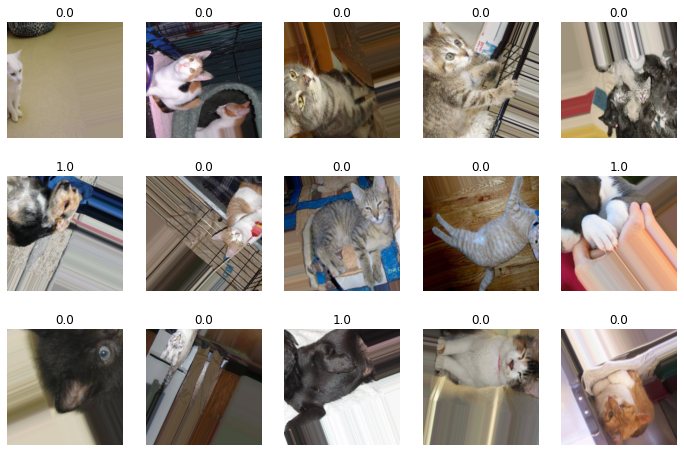

In [21]:
plt.figure(figsize=(12,8))
for i in range(15):
  plt.subplot(3,5,i+1)
  plt.imshow(images[i])
  plt.title(labels[i])
  plt.axis('off')
  # plt.show()

In [18]:
def build_model_3():
  model = keras.Sequential([
      layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(224,224,3)),
      # padding을 넣으면 이미지 외곽에 빈 픽셀을 넣어 전체 사이즈가 변하지 않게 함
      layers.MaxPool2D(2),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPool2D(2),
      layers.Conv2D(128, 3, activation='relu'),
      layers.MaxPool2D(2),
      layers.Conv2D(128, 3, activation='relu'),
      layers.MaxPool2D(2),

      layers.Flatten(),
      layers.Dropout(0.3),
      layers.Dense(256, activation='relu'),
      layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer = 'adam',
      loss = 'binary_crossentropy',
      metrics = ['acc']
  )
  return model

In [19]:
model = build_model_3()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [20]:
EPOCHS = 30

log = model.fit(train_iter,
                epochs = EPOCHS,
                validation_data = val_iter,
                verbose = 1)

Epoch 1/30
63/63 [==============================] - 38s 459ms/step - loss: 0.7113 - acc: 0.5050 - val_loss: 0.6925 - val_acc: 0.5110
Epoch 2/30
63/63 [==============================] - 33s 532ms/step - loss: 0.6936 - acc: 0.5110 - val_loss: 0.6925 - val_acc: 0.5840
Epoch 3/30
63/63 [==============================] - 30s 476ms/step - loss: 0.6856 - acc: 0.5500 - val_loss: 0.6616 - val_acc: 0.5550
Epoch 4/30
63/63 [==============================] - 33s 519ms/step - loss: 0.6852 - acc: 0.5420 - val_loss: 0.6714 - val_acc: 0.5940
Epoch 5/30
63/63 [==============================] - 29s 454ms/step - loss: 0.6812 - acc: 0.5565 - val_loss: 0.6523 - val_acc: 0.5930
Epoch 6/30
63/63 [==============================] - 28s 452ms/step - loss: 0.6690 - acc: 0.5560 - val_loss: 0.6878 - val_acc: 0.5160
Epoch 7/30
63/63 [==============================] - 31s 486ms/step - loss: 0.6887 - acc: 0.5495 - val_loss: 0.6591 - val_acc: 0.5990
Epoch 8/30
63/63 [==============================] - 28s 452ms/step - 

## 검증데이터 분리

In [31]:
train_gen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 90,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    vertical_flip = True,
    horizontal_flip = True,
    validation_split=0.2
    # val 부분을 split하여 나눔눔
)

test_gen = ImageDataGenerator(rescale = 1./255.)

In [32]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

train_iter = train_gen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='binary',
    subset='training'
    # 나눠진 것 중 train iter
)

val_iter = train_gen.flow_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='binary',
    subset='validation'
    # 나눠진 것 중 val iter
) 

test_iter = test_gen.flow_from_directory(
    val_dir,
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE,
    class_mode='binary'
    # val dir에 있는 것을 test로 사용
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
def build_model_2():
  model = keras.Sequential([
      layers.Conv2D(32, 3, activation='relu', input_shape=(224,224,3)),
      layers.MaxPool2D(2),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPool2D(2),
      layers.Conv2D(128, 3, activation='relu'),
      layers.MaxPool2D(2),

      layers.Flatten(),
      layers.Dropout(0.3),
      layers.Dense(256, activation='relu'),
      layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer = 'adam',
      loss = 'binary_crossentropy',
      metrics = ['acc']
  )
  return model

In [28]:
model = build_model_2()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

## model checkpoint

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint

ckpt_path = '/content/checkpoint/checkpoint.ckpt'

ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [47]:
EPOCHS = 10

log = model.fit(train_iter,
                epochs = EPOCHS,
                validation_data = val_iter,
                callbacks = [ckpt_cb],
                verbose = 1)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.6559 - acc: 0.6081
Epoch 1: val_loss improved from inf to 0.65633, saving model to /content/checkpoint/checkpoint.ckpt
50/50 [==============================] - 27s 545ms/step - loss: 0.6559 - acc: 0.6081 - val_loss: 0.6563 - val_acc: 0.5800
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.6573 - acc: 0.5938
Epoch 2: val_loss improved from 0.65633 to 0.65272, saving model to /content/checkpoint/checkpoint.ckpt
50/50 [==============================] - 26s 521ms/step - loss: 0.6573 - acc: 0.5938 - val_loss: 0.6527 - val_acc: 0.6275
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.6518 - acc: 0.6106
Epoch 3: val_loss did not improve from 0.65272
50/50 [==============================] - 25s 502ms/step - loss: 0.6518 - acc: 0.6106 - val_loss: 0.6549 - val_acc: 0.6125
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.6470 - acc: 0.6100
Epoch 4: val_loss did not i

In [48]:
model.load_weights(ckpt_path)

In [49]:
model.evaluate(test_iter)

32/32 [==============================] - 3s 102ms/step - loss: 0.6333 - acc: 0.6210


[0.6333385109901428, 0.6209999918937683]